In [33]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [5]:
from textwrap import dedent

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.externals import joblib # 최근에는 이게 없어지고 joblib으로 대체함
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
seed = 1
np.random.seed(seed)

In [6]:
ROOT = Path.cwd().parent/'data'
enc = joblib.load(ROOT/'encoder.model')
raw_arr = np.load(ROOT/'feat.npy').transpose(0,2,1) #기존 열 (0,1,2) -> transpose 시 (0,2,1)로 변환됨
fft_arr = np.load(ROOT/'feat_fft.npy').transpose(0,2,1)
target = np.load(ROOT/'target.npy')
print(dedent(f'''
Dataset shapes:
    raw: {raw_arr.shape}
    fft: {fft_arr.shape}
    target: {target.shape}
'''))


Dataset shapes:
    raw: (7626, 9, 128)
    fft: (7626, 6, 65)
    target: (7626,)



In [7]:
def create_datasets(data, target, train_size, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(),
        torch.tensor(fft[:sz][trn_idx]).float(),
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[sz:]).float(), 
        torch.tensor(fft[sz:]).float(), 
        torch.tensor(target[sz:]).long())
    return trn_ds, val_ds, tst_ds

In [8]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [9]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.
    
    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

In [10]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [11]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [12]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [13]:
trn_sz = 3810  # only the first `trn_sz` rows in each array include labelled data

In [14]:
datasets = create_datasets((raw_arr, fft_arr), target, trn_sz, seed=seed)

In [16]:
# make sure that we run on a proper device (not relevant for Kaggle kernels but helpful in Jupyter sessions)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [17]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.9264. Acc.: 16.54%
Epoch 1 best model saved with accuracy: 16.54%
Epoch:   2. Loss: 1.8352. Acc.: 19.69%
Epoch 2 best model saved with accuracy: 19.69%
Epoch:   4. Loss: 1.8118. Acc.: 19.69%
Epoch:   8. Loss: 1.8105. Acc.: 19.69%
Epoch 12 best model saved with accuracy: 26.51%
Epoch 13 best model saved with accuracy: 32.02%
Epoch 14 best model saved with accuracy: 32.55%
Epoch 15 best model saved with accuracy: 32.81%
Epoch:  16. Loss: 1.5633. Acc.: 32.55%
Epoch 17 best model saved with accuracy: 33.07%
Epoch 21 best model saved with accuracy: 34.65%
Epoch 22 best model saved with accuracy: 35.70%
Epoch 24 best model saved with accuracy: 36.22%
Epoch 25 best model saved with accuracy: 37.27%
Epoch 26 best model saved with accuracy: 38.32%
Epoch 28 best model saved with accuracy: 39.90%
Epoch 31 best model saved with accuracy: 41.21%
Epoch:  32. Loss: 1.3889. Acc.: 40.16%
Epoch 34 best model saved with accuracy: 43.83%
Epoch 35 best model saved w

In [18]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

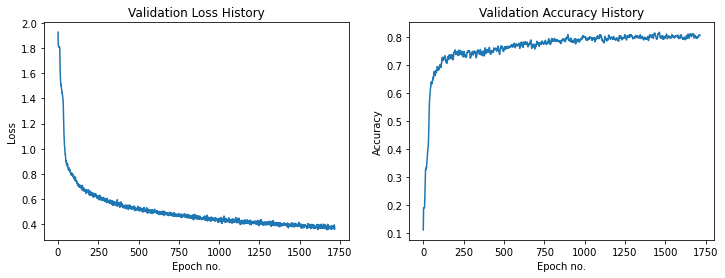

In [19]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [20]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, _ in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [21]:
enc.inverse_transform(test_results)

/home/sunkeun/miniconda3/envs/sk_test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['concrete', 'soft_pvc', 'tiled', ..., 'concrete', 'concrete',
       'wood'], dtype=object)

In [23]:
def cosine(epoch, t_max, ampl):
    """Shifted and scaled cosine function."""
    
    t = epoch % t_max
    return (1 + np.cos(np.pi*t/t_max))*ampl/2

In [24]:
def inv_cosine(epoch, t_max, ampl):
    """A cosine function reflected on X-axis."""
    
    return 1 - cosine(epoch, t_max, ampl)

In [25]:
def one_cycle(epoch, t_max, a1=0.6, a2=1.0, pivot=0.3):
    """A combined schedule with two cosine half-waves."""
    
    pct = epoch / t_max
    if pct < pivot:
        return inv_cosine(epoch, pivot*t_max, a1)
    return cosine(epoch - pivot*t_max, (1-pivot)*t_max, a2)

In [27]:
from functools import partial

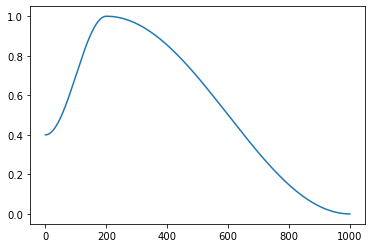

In [28]:
n = 1000
sched = partial(one_cycle, t_max=n, pivot=0.2)
items = [sched(t) for t in range(n)]
plt.plot(items);

In [29]:
class Scheduler:
    """Updates optimizer's learning rates using provided scheduling function."""
    
    def __init__(self, opt, schedule):
        self.opt = opt
        self.schedule = schedule
        self.history = defaultdict(list)
    
    def step(self, t):
        for i, group in enumerate(self.opt.param_groups):
            lr = opt.defaults['lr'] * self.schedule(t)
            group['lr'] = lr
            self.history[i].append(lr)

In [30]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [31]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 128, 3, 1, 1, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [34]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

lr = 0.001
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs*iterations_per_epoch
num_classes = 9
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
iteration = 0
loss_history = []
acc_history = []

model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)

# one-cycle learning rate scheduling
sched = Scheduler(opt, partial(one_cycle, t_max=period, pivot=0.3))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        iteration += 1
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)  # update the learning rate
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch:   1. Loss: 1.9435. Acc.: 16.54%
Epoch 1 best model saved with accuracy: 16.54%
Epoch:   2. Loss: 1.8724. Acc.: 16.54%
Epoch:   4. Loss: 1.7685. Acc.: 16.54%
Epoch 5 best model saved with accuracy: 16.80%
Epoch 7 best model saved with accuracy: 17.06%
Epoch:   8. Loss: 1.6351. Acc.: 17.06%
Epoch 11 best model saved with accuracy: 20.47%
Epoch:  16. Loss: 1.5193. Acc.: 14.44%
Epoch 28 best model saved with accuracy: 21.00%
Epoch 31 best model saved with accuracy: 24.15%
Epoch:  32. Loss: 1.4634. Acc.: 19.69%
Epoch 33 best model saved with accuracy: 24.67%
Epoch 35 best model saved with accuracy: 26.77%
Epoch 39 best model saved with accuracy: 29.66%
Epoch 46 best model saved with accuracy: 32.02%
Epoch 53 best model saved with accuracy: 32.55%
Epoch 55 best model saved with accuracy: 33.60%
Epoch 57 best model saved with accuracy: 33.86%
Epoch 59 best model saved with accuracy: 35.17%
Epoch 61 best model saved with accuracy: 35.70%
Epoch 63 best model saved wi

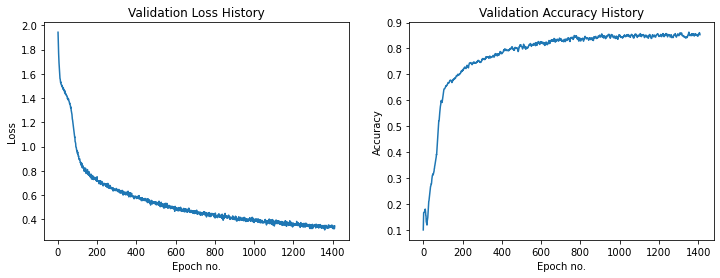

In [35]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [36]:
test_results = []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, _ in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [37]:
enc.inverse_transform(test_results)

/home/sunkeun/miniconda3/envs/sk_test/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['hard_tiles_large_space', 'fine_concrete', 'concrete', ...,
       'concrete', 'concrete', 'wood'], dtype=object)

In [38]:
test_results

[4,
 2,
 1,
 0,
 6,
 1,
 5,
 4,
 8,
 8,
 1,
 1,
 8,
 6,
 2,
 8,
 8,
 6,
 2,
 5,
 8,
 8,
 5,
 4,
 1,
 8,
 1,
 7,
 8,
 4,
 5,
 5,
 1,
 5,
 0,
 5,
 5,
 5,
 5,
 5,
 0,
 8,
 1,
 1,
 5,
 6,
 8,
 1,
 8,
 8,
 8,
 6,
 5,
 8,
 5,
 8,
 7,
 8,
 3,
 4,
 8,
 2,
 8,
 1,
 1,
 2,
 5,
 5,
 5,
 7,
 8,
 5,
 1,
 8,
 4,
 2,
 7,
 5,
 1,
 5,
 6,
 7,
 8,
 7,
 1,
 5,
 2,
 1,
 0,
 1,
 2,
 1,
 6,
 1,
 7,
 2,
 5,
 1,
 6,
 8,
 1,
 4,
 6,
 8,
 8,
 4,
 1,
 3,
 8,
 7,
 5,
 1,
 5,
 2,
 4,
 6,
 8,
 5,
 4,
 5,
 5,
 8,
 2,
 4,
 8,
 8,
 1,
 8,
 2,
 7,
 8,
 5,
 5,
 3,
 2,
 5,
 2,
 8,
 3,
 5,
 6,
 8,
 5,
 5,
 4,
 0,
 1,
 1,
 1,
 4,
 6,
 5,
 0,
 5,
 5,
 5,
 7,
 0,
 1,
 4,
 5,
 4,
 5,
 8,
 3,
 8,
 5,
 4,
 6,
 4,
 1,
 5,
 8,
 3,
 2,
 4,
 7,
 1,
 1,
 4,
 7,
 2,
 5,
 3,
 1,
 4,
 7,
 5,
 8,
 0,
 5,
 8,
 5,
 2,
 5,
 5,
 8,
 6,
 0,
 8,
 1,
 5,
 6,
 4,
 6,
 8,
 5,
 8,
 5,
 1,
 8,
 8,
 5,
 0,
 8,
 2,
 6,
 1,
 5,
 1,
 5,
 5,
 1,
 2,
 8,
 5,
 8,
 5,
 3,
 7,
 8,
 2,
 1,
 5,
 5,
 5,
 5,
 1,
 1,
 5,
 1,
 7,
 1,
 2,
 8,
 2,
 2,
 4,
 0,
 1,
